In [1]:
from math import sqrt

import meshzoo
import torch
torch.set_default_dtype(torch.double) # noqa
from tqdm import tqdm

from torchfem import Shell

import matplotlib.pyplot as plt

In [2]:
# Material parameters
E = 200000
nu = 0.3
C = (E / (1.0 - nu**2)) * torch.tensor(
    [[1.0, nu, 0.0], [nu, 1.0, 0.0], [0.0, 0.0, 0.5 * (1.0 - nu)]]
)
Cs = torch.tensor([[E / (2 * (1 + nu)), 0], [0.0, E / (2 * (1 + nu))]])

# Define nodes and element of the cantilever
X = torch.linspace(0.0, 100.0, 9)
Y = torch.linspace(0.0, 50.0, 9)
points, cells = meshzoo.rectangle_tri(X, Y, variant="zigzag")
N = len(points)
nodes = torch.hstack([torch.tensor(points, dtype=torch.float32), torch.zeros((N, 1))])
elements = cells.tolist()

# Define masks for boundaries
left = nodes[:, 0] < 0.01
tip = (nodes[:, 0] > 99.9) & (nodes[:, 1] < 25.01) & (nodes[:, 1] > 24.99)

# Apply load boundary conditions
forces = torch.zeros((N, 6))
forces[tip, 2] = 50

# Apply displacement boundary conditions
displacements = torch.zeros((N, 6))
constraints = torch.zeros((N, 6), dtype=bool)
constraints[left] = True

# Thickness
thickness = torch.ones(len(elements))

# Define Shell model
cantilever = Shell(
    nodes, elements, forces, displacements, constraints, thickness, C, Cs
)

In [3]:
from scipy.optimize import bisect

# Parameters
iter = 100
vol_frac = 0.5
s = 0.7

# Initial thickness, minimum thickness, maximum thickness
d_0 = 2.5 * torch.ones(len(cantilever.elements), requires_grad=True)
d_min = 0.1 * torch.ones(len(cantilever.elements))
d_max = 5.0 * torch.ones(len(cantilever.elements))

# Compute element-wise areas with one-point integration
J = cantilever.etype.B([0.0, 0.0]) @ cantilever.loc_nodes
areas = torch.linalg.det(J) / 2.0

# Initial volume (50% of maximum available design volume)
V_0 = vol_frac * torch.inner(d_max, areas)

# Lists for compliances, thickness results and asymptotes
comp = []
d = [d_0]
L = []

# Iterate solutions
for k in tqdm(range(iter)):
    # Solve the problem at d_k
    cantilever.thickness = d[k]
    u_k, f_k = cantilever.solve()

    # Evaluation of compliance
    compliance = 0.5 * torch.inner(f_k.ravel(), u_k.ravel())

    # Compute sensitivty thanks to differentiable torchfem solver
    sensitivity = torch.autograd.grad(compliance, d[k])[0]

    # Compute asymptote
    if k <= 1:
        L_k = d[k] - s * (d_max - d_min)
    else:
        L_k = torch.zeros_like(L[k - 1])
        for j in range(len(L_k)):
            if (d[k][j] - d[k - 1][j]) * (d[k - 1][j] - d[k - 2][j]) < 0.0:
                L_k[j] = d[k][j] - s * (d[k - 1][j] - L[k - 1][j])
            else:
                L_k[j] = d[k][j] - 1 / sqrt(s) * (d[k - 1][j] - L[k - 1][j])
    L.append(L_k)

    # Compute lower move limit in this step
    d_min_k = torch.maximum(d_min, 0.9 * L[k] + 0.1 * d[k])

    # Analytical solution
    def d_star(mu):
        d_hat = L[k] + torch.sqrt((-sensitivity * (L[k] - d[k]) ** 2) / (mu * areas))
        return torch.maximum(torch.minimum(d_hat, d_max), d_min_k)

    # Analytical gradient
    def grad(mu):
        return torch.dot(d_star(mu), areas) - V_0

    # Solve dual problem
    with torch.no_grad():
        mu_star = bisect(grad, 1e-10, 1.0)

    # Compute current optimal point with dual solution
    comp.append(compliance.detach())
    d.append(d_star(mu_star))

100%|██████████| 100/100 [00:01<00:00, 67.82it/s]


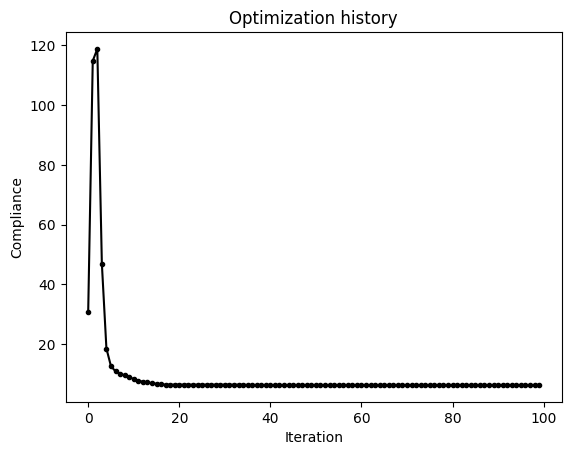

In [4]:
plt.plot(comp, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

In [5]:
# Solve
u, f = cantilever.solve()
cantilever.plot(u[:, 0:3], element_property={"t": cantilever.thickness}, thickness=True)

Widget(value="<iframe src='http://localhost:52239/index.html?ui=P_0x16952d6d0_0&reconnect=auto' style='width: …